In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ankurzing/sentiment-analysis-for-financial-news")

print("Path to dataset files:", path)

/home/ntran4869/miniconda3/envs/mlfinals/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/ntran4869/.cache/kagglehub/datasets/ankurzing/sentiment-analysis-for-financial-news/versions/5


In [15]:
import pandas as pd 

df = pd.read_csv(path + "/all-data.csv", encoding="ISO-8859-1", header=None, names=["sentiment", "text"])
df = df.sample(frac=1).reset_index(drop=True)

In [16]:
df.head()

,sentiment,text
0,neutral,The company said that currently the French dis...
1,positive,`` I am very pleased and proud of our performa...
2,positive,Finnish Cargotec 's Kalmar has received a sign...
3,negative,Since the association 's data do not cover sal...
4,positive,"In the autumn , it plans to expand service to ..."


In [17]:
import nltk
from nltk.corpus import stopwords
from nltk import NaiveBayesClassifier, classify
import random

# # Download Reuters and Stopwords if not already
# nltk.download('reuters')
# nltk.download('stopwords')

# Step 2: Preprocess the data
stop_words = set(stopwords.words('english'))

def preprocess(words):
    return [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]

# Preprocess documents
df = [(preprocess(row['text'].split()), row['sentiment']) for idx, row  in df.iterrows()]

# Step 3: Create a bag-of-words feature extractor
def get_features(words):
    return {word: True for word in words}

# Apply feature extraction
featuresets = [(get_features(txt), senti) for txt, senti in df]

# Step 4: Split into training and testing datasets
train_size = int(len(featuresets) * 0.8)
train_set, test_set = featuresets[:train_size], featuresets[train_size:]

# Train the Naive Bayes Classifier
classifier = NaiveBayesClassifier.train(train_set)

# Evaluate the model
accuracy = classify.accuracy(classifier, test_set)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Show most informative features
classifier.show_most_informative_features(10)


Model Accuracy: 62.89%
Most Informative Features
               decreased = True           negati : positi =     46.9 : 1.0
                    rose = True           positi : neutra =     41.9 : 1.0
                 dropped = True           negati : neutra =     39.5 : 1.0
                    grew = True           positi : neutra =     36.8 : 1.0
             temporarily = True           negati : neutra =     36.3 : 1.0
                positive = True           positi : neutra =     31.2 : 1.0
                compared = True           negati : neutra =     31.2 : 1.0
                    fell = True           negati : neutra =     28.1 : 1.0
              continuing = True           negati : neutra =     26.8 : 1.0
                     lay = True           negati : neutra =     26.8 : 1.0


In [18]:
from polygon import RESTClient
from polygon.rest.models import (
    TickerNews,
)

In [19]:
client = RESTClient(api_key="MzWcQSMDC2RsO1ZnbQBJaiqKJwZv1V6i")

In [20]:
# The polygon API limits
def extract_news(ticker: str, lim = 40):
    news = client.list_ticker_news(ticker,published_utc_gt="2024-01-01T00:00:00Z")
    n = []
    date = []
    for idx, new in enumerate(news):
        n.append(new.description)
        date.append(new.published_utc)
        if idx == lim - 1:
            return n, date
    return n,date


In [21]:
import collections
import matplotlib.pyplot as plt

def plot_senticount(ticker):
    news, dates = extract_news(ticker)
    sent = []
    for new in news:
        sent.append(classifier.classify(get_features(preprocess(new.split()))))
    d = collections.defaultdict(list)
    for idx, date in enumerate(dates):
        d[date[5:7]].append(sent[idx])
    transformed_data = {key: collections.Counter(value) for key, value in d.items()}
    
    # Prepare data for plotting
    sorted_keys = sorted(transformed_data.keys())  # Sort the keys for chronological order
    negative_counts = [transformed_data[key].get('negative', 0) for key in sorted_keys]
    positive_counts = [transformed_data[key].get('positive', 0) for key in sorted_keys]
    neutral_counts = [transformed_data[key].get('neutral', 0) for key in sorted_keys]

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_keys, negative_counts, label="Negative", marker="o", color="red")
    plt.plot(sorted_keys, positive_counts, label="Positive", marker="o", color="green")
    plt.plot(sorted_keys, neutral_counts, label="Neutral", marker="o", color="blue")

    # Add labels, title, and legend
    plt.xlabel("Time Period (Keys)")
    plt.ylabel("Sentiment Count")
    plt.title("Sentiment Counts Over Time Of Stock " + ticker)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()
            

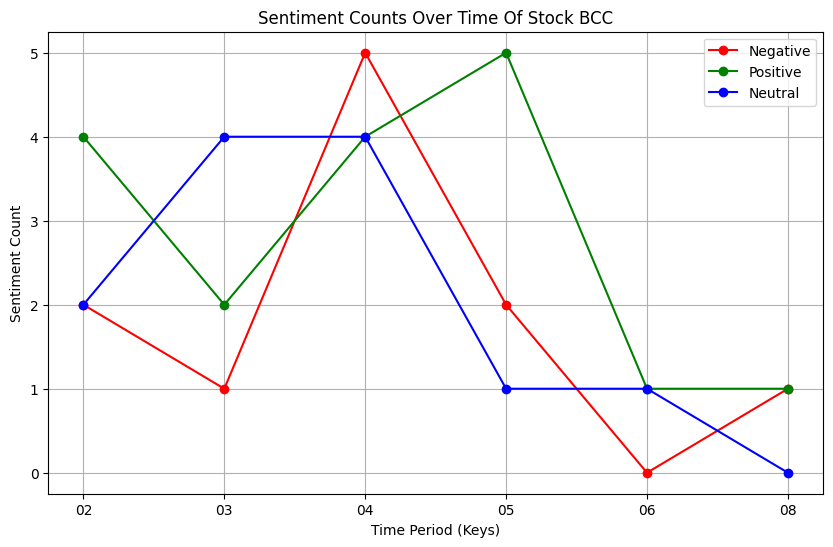

In [22]:
plot_senticount("BCC")

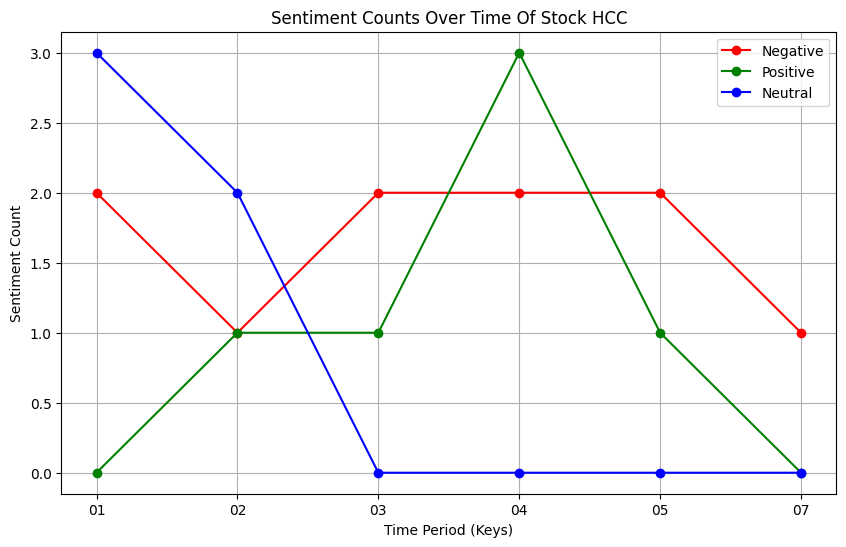

In [24]:
plot_senticount("HCC")